<a href="https://colab.research.google.com/github/VadPA/PyTorch/blob/master/Lesson_4_hw_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import pickle
import os

In [2]:
import matplotlib.pyplot as plt
from torchsummary import summary

In [3]:
def load_labels_name(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [4]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [5]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [6]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [7]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

In [8]:
train_dataset, valid_dataset = train_valid_split(dataset)

In [9]:
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [11]:
files = os.listdir('data/cifar-100-python')
print(files)

['file.txt~', 'test', 'train', 'meta']


In [12]:
data_cifar100 = load_labels_name('data/cifar-100-python/meta')

In [13]:
classes_cifar100 = data_cifar100['fine_label_names']

torch.Size([128, 3, 32, 32])
can


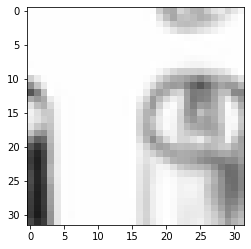

In [14]:
for img, lbl in train_loader:
    print(img.shape)
    print(classes_cifar100[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60) 
        self.conv_two = torch.nn.Conv2d(60, 90, 3)
        self.bn_three = torch.nn.BatchNorm2d(90)
        self.conv_three = torch.nn.Conv2d(90, 150, 3)
        self.bn_four = torch.nn.BatchNorm2d(150)
        self.fc1 = torch.nn.Linear(600, 300)
        self.fc2 = torch.nn.Linear(300, 160)
        self.out = torch.nn.Linear(160, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

In [17]:
net = Net()
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(60, 90, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(90, 150, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)


In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [19]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 60, 30, 30]           1,680
       BatchNorm2d-3           [-1, 60, 15, 15]             120
            Conv2d-4           [-1, 90, 13, 13]          48,690
       BatchNorm2d-5             [-1, 90, 6, 6]             180
            Conv2d-6            [-1, 150, 4, 4]         121,650
       BatchNorm2d-7            [-1, 150, 2, 2]             300
           Dropout-8                  [-1, 600]               0
            Linear-9                  [-1, 300]         180,300
          Dropout-10                  [-1, 300]               0
           Linear-11                  [-1, 160]          48,160
           Linear-12                  [-1, 100]          16,100
Total params: 417,186
Trainable params: 417,186
Non-trainable params: 0
-------------------------------

In [20]:
num_epochs = 5
net.train()

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(60, 90, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(90, 150, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)

In [21]:
for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels  == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader, 0):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.000. Test acc: 0.010
Epoch [1/5]. Step [301/372]. Loss: 0.031. Acc: 0.091. Test acc: 0.102
Epoch [2/5]. Step [1/372]. Loss: 0.030. Acc: 0.086. Test acc: 0.111
Epoch [2/5]. Step [301/372]. Loss: 0.027. Acc: 0.159. Test acc: 0.133
Epoch [3/5]. Step [1/372]. Loss: 0.025. Acc: 0.195. Test acc: 0.157
Epoch [3/5]. Step [301/372]. Loss: 0.026. Acc: 0.200. Test acc: 0.168
Epoch [4/5]. Step [1/372]. Loss: 0.025. Acc: 0.203. Test acc: 0.167
Epoch [4/5]. Step [301/372]. Loss: 0.025. Acc: 0.226. Test acc: 0.185
Epoch [5/5]. Step [1/372]. Loss: 0.023. Acc: 0.289. Test acc: 0.177
Epoch [5/5]. Step [301/372]. Loss: 0.024. Acc: 0.243. Test acc: 0.210
Training is finished!


In [22]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=1)

In [23]:
data_iter = iter(valid_loader)
inputs, labels = data_iter.next()
labels = labels.to(device)
inputs = inputs.to(device)
labels

tensor([82, 57, 19, 96, 14, 45, 51, 17])

In [24]:
import torchvision

GroundTruth:  sunflower pear cattle willow_tree butterfly lobster mushroom castle


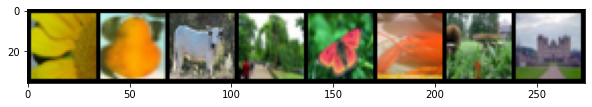

In [25]:
net.eval()
outputs = net(inputs)
imgs = torchvision.utils.make_grid(inputs.to('cpu'))
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes_cifar100[labels[j]] for j in range(len(labels))))

In [26]:
print(outputs)

tensor([[ 2.0522e+00,  1.1617e+00, -3.7484e+00, -2.3105e+00, -3.6977e+00,
         -1.9903e+00,  1.1377e+00,  3.0492e-01, -3.3720e+00,  4.1147e-01,
          3.6961e-01, -2.7824e+00, -3.7947e+00, -3.4309e+00,  6.4624e-01,
         -2.9165e+00, -1.7233e+00, -4.5387e+00,  1.2029e+00, -1.3402e+00,
         -3.3675e+00, -4.3189e+00, -1.2021e+00, -2.8349e+00, -1.0764e+00,
         -1.1063e+00, -1.4481e+00, -2.6059e+00, -4.2395e-01, -1.5998e+00,
         -4.8768e+00, -4.5766e+00, -5.6674e-01, -1.1731e+00, -1.7883e+00,
         -2.7121e+00, -2.2277e+00, -4.4266e+00, -2.3725e+00, -6.7370e-01,
         -1.3257e+00, -8.8381e-01, -3.1087e+00, -3.2240e+00,  1.2696e-01,
         -1.6208e+00, -2.1235e+00, -6.1549e-01, -3.5540e+00, -1.1052e+00,
         -2.3318e+00, -1.5109e-01, -3.8883e+00,  2.0030e+00,  4.2311e-01,
         -2.3950e+00, -3.1236e+00,  1.4178e+00, -3.4862e+00, -3.5138e+00,
         -5.8538e-01,  2.9714e-01,  2.4880e+00, -4.4005e+00, -3.2733e+00,
         -1.7257e+00, -3.9399e+00, -6.

In [27]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([82, 53, 48, 83, 62, 47,  8, 89])

In [28]:
print('Predicted: ', ' '.join(classes_cifar100[predicted[j]] for j in range(len(labels))))

Predicted:  sunflower orange motorcycle sweet_pepper poppy maple_tree bicycle tractor


In [29]:
gt = np.array([classes_cifar100[labels[j]] for j in range(len(labels))])
pred = np.array([classes_cifar100[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt):.4f}')

['sunflower' 'pear' 'cattle' 'willow_tree' 'butterfly' 'lobster'
 'mushroom' 'castle']
['sunflower' 'orange' 'motorcycle' 'sweet_pepper' 'poppy' 'maple_tree'
 'bicycle' 'tractor']
Accuracy is 0.1250


In [30]:
from torchvision import models

In [31]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [33]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [34]:
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, out_features=len(classes_cifar100))

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [35]:
resnet50 = resnet50.to(device)

In [36]:
train_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(32),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [37]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [38]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [39]:
num_epochs = 5
resnet50.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.008. Test acc: 0.013
Epoch [1/5]. Step [301/372]. Loss: 0.029. Acc: 0.169. Test acc: 0.192
Epoch [2/5]. Step [1/372]. Loss: 0.027. Acc: 0.188. Test acc: 0.185
Epoch [2/5]. Step [301/372]. Loss: 0.026. Acc: 0.227. Test acc: 0.204
Epoch [3/5]. Step [1/372]. Loss: 0.024. Acc: 0.273. Test acc: 0.202
Epoch [3/5]. Step [301/372]. Loss: 0.026. Acc: 0.239. Test acc: 0.225
Epoch [4/5]. Step [1/372]. Loss: 0.025. Acc: 0.273. Test acc: 0.214
Epoch [4/5]. Step [301/372]. Loss: 0.025. Acc: 0.253. Test acc: 0.224
Epoch [5/5]. Step [1/372]. Loss: 0.024. Acc: 0.266. Test acc: 0.229
Epoch [5/5]. Step [301/372]. Loss: 0.025. Acc: 0.257. Test acc: 0.220
Training is finished!


In [41]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=1)

In [54]:
data_iter = iter(valid_loader)
inputs, labels = data_iter.next()
labels = labels.to(device)
inputs = inputs.to(device)
labels

tensor([69, 77, 94, 18,  3, 56, 95, 39])

GroundTruth:  rocket snail wardrobe caterpillar bear palm_tree whale keyboard


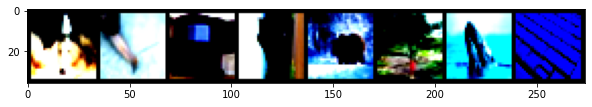

In [55]:
net.eval()
outputs = resnet50(inputs)
imgs = torchvision.utils.make_grid(inputs.to('cpu'))
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes_cifar100[labels[j]] for j in range(len(labels))))

In [56]:
print(outputs)

tensor([[-3.7040e+00, -2.6482e+00, -2.9928e+00, -1.5147e+00, -1.5840e+00,
         -3.8318e+00, -2.7365e+00, -3.0227e+00, -3.8721e+00, -4.1509e+00,
         -2.6285e+00, -2.9298e+00, -5.1387e+00, -5.5398e+00, -4.5120e+00,
         -1.1454e+00, -5.1291e+00, -5.1476e+00, -4.8396e+00, -1.5201e+00,
         -5.7104e+00, -3.4040e+00, -3.8152e+00, -3.8927e+00, -3.6209e+00,
         -4.2822e+00, -2.2787e+00, -2.7726e+00, -3.7745e+00, -2.8436e+00,
         -6.7671e+00, -2.1252e+00, -2.3617e+00, -4.3859e+00, -7.7117e-01,
         -2.5201e+00, -1.2879e+00, -5.9095e+00, -9.9664e-01, -7.4050e+00,
         -3.6309e+00, -3.3469e+00, -2.4062e+00, -1.1591e+00, -1.1208e+00,
         -3.3344e+00, -3.0190e+00, -6.6182e+00, -4.2227e+00, -4.8393e+00,
         -1.5446e+00, -1.8981e+00, -6.6457e+00, -4.8021e+00, -4.5604e+00,
         -1.8737e+00, -5.3158e+00, -1.9117e+00, -5.2232e+00, -4.8221e+00,
         -5.4632e+00, -4.7753e+00, -5.8441e+00, -4.3323e-01, -9.2769e-01,
         -9.2285e-01, -2.8677e+00, -2.

In [57]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([63,  7, 94, 54, 65, 56, 95, 39])

In [58]:
print('Predicted: ', ' '.join(classes_cifar100[predicted[j]] for j in range(len(labels))))

Predicted:  porcupine beetle wardrobe orchid rabbit palm_tree whale keyboard


In [59]:
gt = np.array([classes_cifar100[labels[j]] for j in range(len(labels))])
pred = np.array([classes_cifar100[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt):.4f}')

['rocket' 'snail' 'wardrobe' 'caterpillar' 'bear' 'palm_tree' 'whale'
 'keyboard']
['porcupine' 'beetle' 'wardrobe' 'orchid' 'rabbit' 'palm_tree' 'whale'
 'keyboard']
Accuracy is 0.5000
